In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

print(f"tensorflow version: {tf.__version__}")


tensorflow version: 2.12.0


In [2]:
# Set up paths for data
train_dr = 'E:/Github Repo/Competition/data/pneumonia_data/chest_xray/train'
val_dr = 'E:/Github Repo/Competition/data/pneumonia_data/chest_xray/val'
test_dr = 'E:/Github Repo/Competition/data/pneumonia_data/chest_xray/test'

In [3]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dr,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
val_data = val_datagen.flow_from_directory(
    val_dr,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
test_data = test_datagen.flow_from_directory(
    test_dr,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Development

In [4]:
# Define the hypermodel
def build_model(hp):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(
        filters=hp.Choice('filters_1', values=[32, 64, 96]),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_1', values=[0.001, 0.01, 0.05])),
        input_shape=(150, 150, 3)
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp.Choice('dropout_1', values=[0.3, 0.4, 0.5])))
    
    # Second Convolutional Layer
    model.add(Conv2D(
        filters=hp.Choice('filters_2', values=[32, 64, 96]),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_2', values=[0.001, 0.01, 0.05]))
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp.Choice('dropout_2', values=[0.3, 0.4, 0.5])))

    # Third Convolutional Layer
    model.add(Conv2D(
        filters=hp.Choice('filters_3', values=[64, 128, 192]),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_3', values=[0.001, 0.01, 0.05]))
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(
        units=hp.Choice('dense_units', values=[128, 256, 512]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Choice('dropout_dense', values=[0.5, 0.6, 0.7])))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model



In [5]:
log_dir = "logs/hyperparameter_tuning"
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [6]:
# Set up the tuner with adjusted parameter intervals
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and evaluate for each trial
    directory='tuner_logs',
    project_name='chest_xray_tuning'
)

In [7]:
# Search for the best hyperparameters
tuner.search(train_data, epochs=10, validation_data=val_data, callbacks=[tensorboard_callback])

Trial 10 Complete [00h 16m 22s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.8125
Total elapsed time: 03h 23m 22s


In [8]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [9]:
# Evaluate the best model on the test set
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


20/20 [==============================] - 11s 527ms/step - loss: 0.4943 - accuracy: 0.8013 - precision: 0.8050 - recall: 0.9000
Test Accuracy: 0.8012820482254028
Test Precision: 0.8050458431243896
Test Recall: 0.8999999761581421


In [10]:
# Plot training history for best model
history = best_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/10
163/163 [==============================] - 147s 895ms/step - loss: 0.4348 - accuracy: 0.7924 - precision: 0.8059 - recall: 0.9492 - val_loss: 0.6917 - val_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 2/10
163/163 [==============================] - 146s 893ms/step - loss: 0.4166 - accuracy: 0.7985 - precision: 0.8125 - recall: 0.9474 - val_loss: 0.6591 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 3/10
163/163 [==============================] - 146s 893ms/step - loss: 0.4074 - accuracy: 0.8370 - precision: 0.8587 - recall: 0.9345 - val_loss: 0.6718 - val_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 4/10
163/163 [==============================] - 147s 897ms/step - loss: 0.4058 - accuracy: 0.8462 - precision: 0.8661 - recall: 0.9381 - val_loss: 0.7192 - val_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 5/10
163/163 [==============================] - 146s 892ms/step - loss: 0.3913 - a

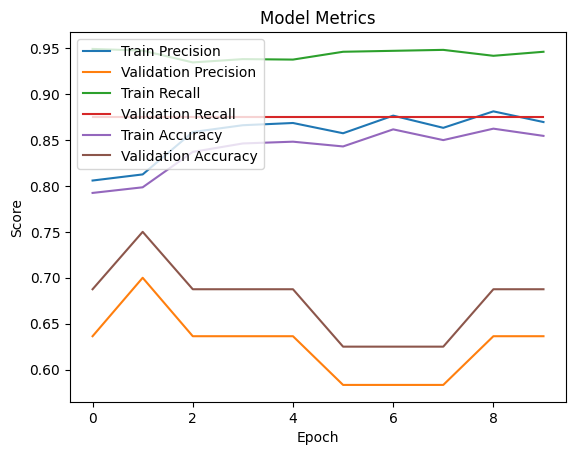

In [11]:
# Plot metrics for the best model
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.show()

Remove-Item -Recurse -Force .\logs\hyperparameter_tuning 

py -m tensorboard.main --logdir=logs/hyperparameter_tuning